<h1 align=center>Diagnosing Heart Disease</h1>
<h2 align=center>Using ML Tools and Techniques</h2>
</br>

<img style="  display: block;
              margin-left: auto;
              margin-right: auto;
              width: 40%;" 
     src="https://cdn.shopify.com/s/files/1/2294/9791/products/neon_heart_red_2_820x.jpg?v=1568665650"/>

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input"))
import matplotlib.pyplot as plt
import seaborn as sns

# Data splitting/parameter tuning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


# ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Feature processing
from sklearn.feature_selection import SelectPercentile, chi2

# Evaluation metrics
from sklearn.metrics import confusion_matrix

Load the data.

In [3]:
heart_path = "../input/heart.csv"
heart_data = pd.read_csv(heart_path)

In [4]:
heart_data.head(5)

age  sex  cp  trestbps  chol   ...    oldpeak  slope  ca  thal  target
0   63    1   3       145   233   ...        2.3      0   0     1       1
1   37    1   2       130   250   ...        3.5      0   0     2       1
2   41    0   1       130   204   ...        1.4      2   0     2       1
3   56    1   1       120   236   ...        0.8      2   0     2       1
4   57    0   0       120   354   ...        0.6      2   0     2       1

[5 rows x 14 columns]

# Columns

* **age:** The person's age in years
* **sex:** The person's sex (1 = male, 0 = female)
* **cp:** The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
* **trestbps:** The person's resting blood pressure (mm Hg on admission to the hospital)
* **chol:** The person's cholesterol measurement in mg/dl
* **fbs:** The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
* **restecg:** Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
* **thalach:** The person's maximum heart rate achieved
* **exang:** Exercise induced angina (1 = yes; 0 = no)
* **oldpeak:** ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more here)
* **slope:** the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
* **ca:** The number of major vessels (0-3)
* **thal:** A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
* **target:** Heart disease (0 = no, 1 = yes)

In [5]:
print("Heart data shape is:", heart_data.shape[0], "x", heart_data.shape[1])

Heart data shape is: 303 x 14


In [6]:
# Missing values
heart_data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

# Data exploration

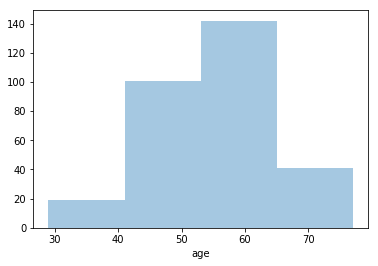

In [7]:
sns.distplot(heart_data["age"], bins=4, kde=False)

* **Approximately, 80% of the people are in the range of 41-65.**

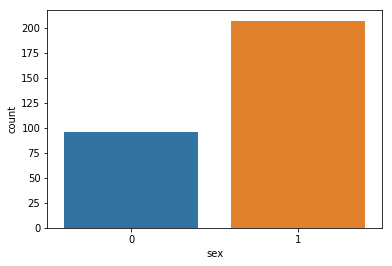

In [8]:
sns.countplot(heart_data["sex"])

* **More than 2/3 of the population in the dataset are male**

In [9]:
total = len(heart_data["sex"])
males = heart_data["sex"].sum()
females = len(heart_data["sex"]) - males
print("Porcentage of males:", round(males/total*100, 3))
print("procentage of females:", round(females/total*100, 3))

Porcentage of males: 68.317
procentage of females: 31.683


Text(0, 0.5, 'amount')

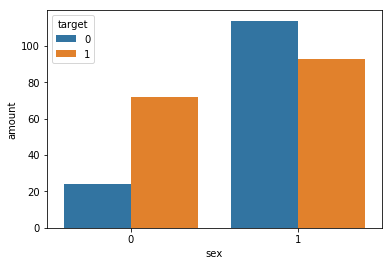

In [10]:
sex_graph = sns.countplot(heart_data["sex"], hue=heart_data["target"])
sex_graph.set_ylabel("amount")

* **There are not a huge disparity between the number of healthy and unhealthy men. The difference is more notoriuos for females.**

Text(0, 0.5, 'amount')

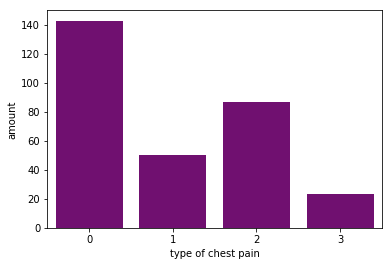

In [11]:
cp_graph = sns.countplot(heart_data["cp"], color="purple")
cp_graph.set_xlabel("type of chest pain")
cp_graph.set_ylabel("amount")

* **Almost, half of the people are asymptomatic.**

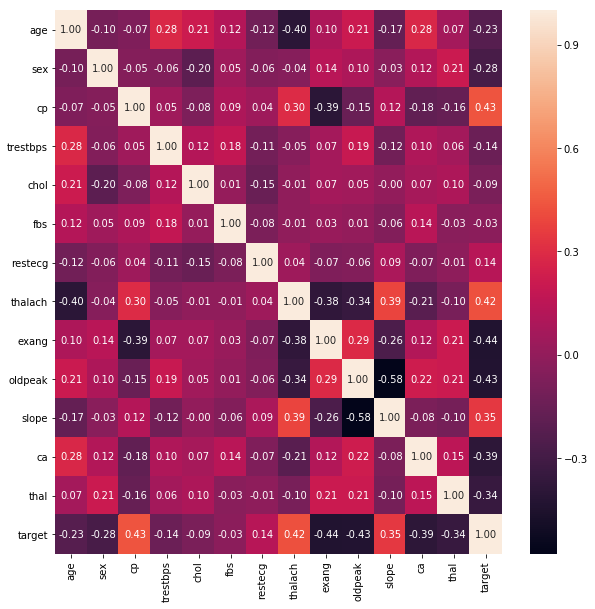

In [12]:
plt.figure(figsize=(10, 10))
sns.heatmap(heart_data.corr(), annot=True, fmt='.2f')

* **A summary of the correlation of every pair of features. The ones that are more correlated with the target are cp, thalach and slop in that order. This is a good way to later select the most promising features for our final model, although there are other more sophisticated and automated ways to select the best features.**

# Preprocessing data

In [13]:
heart_data.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

Due to the description of the features, some of them are categorical not numbers.

In [14]:
heart_data['sex'] = heart_data['sex'].astype('object')
heart_data['cp'] = heart_data['cp'].astype('object')
heart_data['fbs'] = heart_data['fbs'].astype('object')
heart_data['restecg'] = heart_data['restecg'].astype('object')
heart_data['exang'] = heart_data['exang'].astype('object')
heart_data['slope'] = heart_data['slope'].astype('object')
heart_data['thal'] = heart_data['thal'].astype('object')

In [15]:
heart_data.dtypes

age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca            int64
thal         object
target        int64
dtype: object

In [16]:
heart_data = pd.get_dummies(heart_data)
heart_data.head()

age  trestbps  chol  thalach   ...    thal_0  thal_1  thal_2  thal_3
0   63       145   233      150   ...         0       1       0       0
1   37       130   250      187   ...         0       0       1       0
2   41       130   204      172   ...         0       0       1       0
3   56       120   236      178   ...         0       0       1       0
4   57       120   354      163   ...         0       0       1       0

[5 rows x 27 columns]

In [17]:
print("Heart data shape is:", heart_data.shape[0], "x", heart_data.shape[1])

Heart data shape is: 303 x 27


# Machine learning

In [18]:
# Getting features and target
X = heart_data.drop(["target"], axis=1)
y = heart_data["target"]

In [19]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_predictions = cross_val_predict(rf_model, X, y, cv=5)
print(confusion_matrix(y, rf_predictions))
rf_scores = cross_val_score(rf_model, X, y, scoring="recall", cv=5)
print("recall:", rf_scores.mean())

[[113  25]
 [ 29 136]]
recall: 0.8424242424242424


In [20]:
# Logistic Regression
lr_model = LogisticRegression(solver="liblinear")
lr_predictions = cross_val_predict(lr_model, X, y, cv=5)
print(confusion_matrix(y, lr_predictions))
lr_scores = cross_val_score(lr_model, X, y, scoring="recall", cv=5)
print("recall:", lr_scores.mean())

[[106  32]
 [ 23 142]]
recall: 0.8606060606060606


In [21]:
# Support Vector Machine
svc_model = SVC(gamma="auto")
svc_predictions = cross_val_predict(svc_model, X, y, cv=5)
print(confusion_matrix(y, svc_predictions))
svc_scores = cross_val_score(svc_model, X, y, scoring="recall", cv=5)
print("recall:", svc_scores.mean())

[[  8 130]
 [  2 163]]
recall: 0.9878787878787879


In [22]:
# Naive Bayes
nb_model = GaussianNB()
nb_predictions = cross_val_predict(nb_model, X, y, cv=5)
print(confusion_matrix(y, nb_predictions))
nb_scores = cross_val_score(nb_model, X, y, scoring="recall", cv=5)
print("recall:", nb_scores.mean())

[[108  30]
 [ 29 136]]
recall: 0.8242424242424242


In [23]:
# XGBoost (The most popular model for kaggle competitions)
xgb_model = XGBClassifier()
xgb_predictions = cross_val_predict(nb_model, X, y, cv=5)
print(confusion_matrix(y, xgb_predictions))
xgb_scores = cross_val_score(xgb_model, X, y, scoring="recall", cv=5)
print("recall:", xgb_scores.mean())

[[108  30]
 [ 29 136]]
recall: 0.8303030303030304


On average, four models have a similar performance. The support vector machine was the only one that had clearly a different performance. A really good number for recall, but if we do the math for other metrics the numbers are not that impressive.

# Focus on SVM

Besides that, SVM is showing the most interesting results. Due to the fact that is  already doing a great job on false negatives (but having a hard time knowing when someone is not sick). However I think it is a good idea to choose SVM as main model.

# Feature scaling

In [24]:
X["age"] = X["age"].map(lambda x: (x - X["age"].min()) / (X["age"].max() - X["age"].min()))
X["trestbps"] = X["trestbps"].map(lambda x: (x - X["trestbps"].min()) / (X["trestbps"].max() - X["trestbps"].min()))
X["chol"] = X["chol"].map(lambda x: (x - X["chol"].min()) / (X["chol"].max() - X["chol"].min()))
X["thalach"] = X["thalach"].map(lambda x: (x - X["thalach"].min()) / (X["thalach"].max() - X["thalach"].min()))
X["oldpeak"] = X["oldpeak"].map(lambda x: (x - X["oldpeak"].min()) / (X["oldpeak"].max() - X["oldpeak"].min()))

In [25]:
# Support Vector Machine
svc_model = SVC(gamma="auto")
svc_predictions = cross_val_predict(svc_model, X, y, cv=5)
print(confusion_matrix(y, svc_predictions))
svc_scores = cross_val_score(svc_model, X, y, scoring="recall", cv=5)
print("recall:", svc_scores.mean())

[[105  33]
 [ 16 149]]
recall: 0.9030303030303031


The recall now is lower, but applying feature scaling, the SVM is doing a better job classifying the people in general. It is a more robust classifier compared to the previous one.

# Feature selection

In [26]:
best_recall = 0
for n in range(1, 101):
    X_new = SelectPercentile(chi2, percentile=n).fit_transform(X, y)

    svc_model = SVC(gamma="auto")
    svc_predictions = cross_val_predict(svc_model, X_new, y, cv=5)
    svc_scores = cross_val_score(svc_model, X_new, y, scoring="recall", cv=5)
    
    if svc_scores.mean() > best_recall:
        best_recall = svc_scores.mean()
        print(confusion_matrix(y, svc_predictions))
        print("the best porcentage so far:", n)
        print("the best recall so far", svc_scores.mean(), "\n")
        

[[ 92  46]
 [ 34 131]]
the best porcentage so far: 1
the best recall so far 0.793939393939394 

[[102  36]
 [ 19 146]]
the best porcentage so far: 9
the best recall so far 0.884848484848485 

[[104  34]
 [ 17 148]]
the best porcentage so far: 17
the best recall so far 0.8969696969696971 

[[109  29]
 [ 15 150]]
the best porcentage so far: 21
the best recall so far 0.9090909090909092 

[[108  30]
 [ 14 151]]
the best porcentage so far: 33
the best recall so far 0.9151515151515153 



In [27]:
X_new = SelectPercentile(chi2, percentile=33).fit_transform(X, y)        
svc_model = SVC(gamma="auto")
svc_predictions = cross_val_predict(svc_model, X_new, y, cv=5)
print(confusion_matrix(y, svc_predictions))
svc_scores = cross_val_score(svc_model, X_new, y, scoring="recall", cv=5)
print("recall:", svc_scores.mean(), "\n")

print("Old number of features used:",X.shape[1])
print("New number of features used:",X_new.shape[1])

[[108  30]
 [ 14 151]]
recall: 0.9151515151515153 

Old number of features used: 26
New number of features used: 9


Using feature selection, we got rid of irrelevant features and now we are using just the ones that make our model better. Before we used 26 features, now we are using just 9 of them. Roughly 1/3 of them.

If you are curious about what are the features we are using run the cell below. They are, the nine that have the highest correlation with the target.

In [28]:
# EXPLORE FOR BETTER WAY TO KNOW BEST FEATURES AFTER FEATURE SELECTION

#plt.figure(figsize=(20, 20))
#sns.heatmap(heart_data.corr(), annot=True, fmt='.2f')

# Cross validation for parameter tuning

In [29]:


Cs = [1, 10, 100, 1000]
kernels = ["linear", "rbf", "poly"]

for c in Cs:
    for k in kernels:
        
        print("C:", c)
        print("Kernel:", k)
        svc_model = SVC(gamma="auto", C=c, kernel=k)
        svc_predictions = cross_val_predict(svc_model, X_new, y, cv=5)
        print(confusion_matrix(y, svc_predictions))
        svc_scores = cross_val_score(svc_model, X_new, y, scoring="recall", cv=5)
        print("recall:", svc_scores.mean(), "\n")




C: 1
Kernel: linear
[[111  27]
 [ 24 141]]
recall: 0.8545454545454547 

C: 1
Kernel: rbf
[[108  30]
 [ 14 151]]
recall: 0.9151515151515153 

C: 1
Kernel: poly
[[ 86  52]
 [  8 157]]
recall: 0.9515151515151515 

C: 10
Kernel: linear
[[106  32]
 [ 20 145]]
recall: 0.8787878787878789 

C: 10
Kernel: rbf
[[109  29]
 [ 24 141]]
recall: 0.8545454545454547 

C: 10
Kernel: poly
[[108  30]
 [ 17 148]]
recall: 0.8969696969696971 

C: 100
Kernel: linear
[[107  31]
 [ 22 143]]
recall: 0.8666666666666668 

C: 100
Kernel: rbf
[[108  30]
 [ 25 140]]
recall: 0.8484848484848484 

C: 100
Kernel: poly
[[107  31]
 [ 20 145]]
recall: 0.8787878787878789 

C: 1000
Kernel: linear
[[108  30]
 [ 22 143]]
recall: 0.8666666666666668 

C: 1000
Kernel: rbf
[[112  26]
 [ 27 138]]
recall: 0.8363636363636363 

C: 1000
Kernel: poly
[[105  33]
 [ 27 138]]
recall: 0.8363636363636363 

